# Fast sweeping eikonal solver for 2D TTI media with v(x,z) velocity and constant anisotropy

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd "/content/gdrive/My Drive/Colab Notebooks/Codes/PINN_anisotropic_eikonal/fast_sweeping"

In [3]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fseikonal.TTI.ttieikonal as ttieik
import fseikonal.TTI.facttieikonal as fttieik
import time as tm

In [4]:
for hby in [1,2,4]:


    print(f'Running with h/{hby}: \n')
    # Point-source location
    sz = 0.3; sx = 0.2;

    zmin = 0.; zmax = 1.; dz = 0.01/hby;
    xmin = 0.; xmax = 1.; dx = 0.01/hby;

    z = np.arange(zmin,zmax+dz,dz)
    nz = z.size

    x = np.arange(xmin,xmax+dx,dx)
    nx = x.size


    Z,X = np.meshgrid(z,x,indexing='ij')

    v0 = 2.; # Velocity at the origin of the model
    vergrad = 1.5; # Vertical gradient
    horgrad = 0.5; # Horizontal gradient

    # Preparing velocity model
    vs = v0 + vergrad*sz + horgrad*sx # Velocity at the source location
    vz = vs + vergrad*(Z-sz) + horgrad*(X-sx);

    epsilon = 0.2*np.ones((nz,nx))
    delta = 0.1*np.ones((nz,nx))
    theta = 30.*np.ones((nz,nx))*(mt.pi/180)

    eta = (epsilon-delta)/(1+2*delta)
    vx = vz*np.sqrt(1+2*epsilon)

    # Number of fast sweeping iterations
    niter = 2

    # Number of fixed point iterations 
    nfpi = 5

    # Source indices
    isz = int(round((sz-zmin)/dz))
    isx = int(round((sx-xmin)/dx))

    print(f"Source location: (sz,sx) = ({sz},{sx})")
    print(f"Source indices: (isz,isx) = ({isz},{isx})")

    # Checking if the source-point does not lie on the computation grid
    if abs(int(sz/dz)-sz/dz)>1e-8 or abs(int(sx/dx)-sx/dx)>1e-8:
        raise ValueError('Source point not on the computation grid \n Either reduce grid spacing or change the source location.')


    # Analytical solution for the known traveltime part

    # Velocity at the source location

    vzs = vz[isz,isx]
    vxs = vx[isz,isx]
    thetas = theta[isz,isx]

    a0 = vxs**2*np.cos(thetas)**2 + vzs**2*np.sin(thetas)**2
    b0 = vzs**2*np.cos(thetas)**2 + vxs**2*np.sin(thetas)**2
    c0 = np.sin(thetas)*np.cos(thetas)*(vzs**2-vxs**2)


    T0 = np.sqrt((b0*(X-sx)**2 + 2*c0*(X-sx)*(Z-sz) + a0*(Z-sz)**2)/(a0*b0-c0**2)); 

    px0 = np.divide(b0*(X-sx) + c0*(Z-sz), T0*(a0*b0-c0**2), out=np.zeros_like(T0), where=T0!=0)
    pz0 = np.divide(a0*(Z-sz) + c0*(X-sx), T0*(a0*b0-c0**2), out=np.zeros_like(T0), where=T0!=0)

    # Initialize right hand side function to 1
    rhs = np.ones((nz,nx))

    # Placeholders to compute change in traveltime on each fixed-point iteration
    tn = np.zeros((nz,nx))
    tn1 = np.zeros((nz,nx))

    time_start = tm.time()
    for loop in range(nfpi):
        # Run the initializer
        tau = fttieik.fastsweep_init2d(nz, nx, dz, dx, isz, isx, zmin, zmax)

        # Run the fast sweeping iterator
        fttieik.fastsweep_run2d(tau, T0, pz0, px0, vz, vx, theta, niter, nz, nx, dz, dx, isz, isx, rhs)
        
        pz = T0*np.gradient(tau,dz,axis=0,edge_order=2) + tau*pz0
        px = T0*np.gradient(tau,dx,axis=1,edge_order=2) + tau*px0
        
        pxdash = np.cos(theta)*px + np.sin(theta)*pz
        pzdash = np.cos(theta)*pz - np.sin(theta)*px
        
        rhs = 1 + ((2*eta*vx**2*vz**2)/(1+2*eta))*(pxdash**2)*(pzdash**2)
        
        tn1 = tn
        tn  = tau*T0
        print(f'L1 norm of update {np.sum(np.abs(tn1-tn))/(nz*nx)}')
        

    Tfac = (tau*T0)[::hby,::hby]
    exec(f'Tfac{hby} = Tfac') # This will assign traveltimes to variables called Tfac1, Tfac2, and Tfac4

    time_end = tm.time()
    print('FD modeling runtime:', (time_end - time_start), 's')


    if hby==1:

        print(f'\nRunning for first-order regular fast sweeping method')
        # Initialize right hand side function to 1
        rhs = np.ones((nz,nx))

        # Placeholders to compute change in traveltime on each fixed-point iteration
        tn = np.zeros((nz,nx))
        tn1 = np.zeros((nz,nx))

        time_start = tm.time()
        for loop in range(nfpi):
            # Run the initializer
            T = ttieik.fastsweep_init2d(nz, nx, dz, dx, isz, isx, zmin, zmax)

            # Run the fast sweeping iterator
            ttieik.fastsweep_run2d(T, vz, vx, theta, niter, nz, nx, dz, dx, isz, isx, rhs)
            
            pz = np.gradient(T,dz,axis=0,edge_order=2)
            px = np.gradient(T,dx,axis=1,edge_order=2)
            
            pxdash = np.cos(theta)*px + np.sin(theta)*pz
            pzdash = np.cos(theta)*pz - np.sin(theta)*px
            
            rhs = 1 + ((2*eta*vx**2*vz**2)/(1+2*eta))*(pxdash**2)*(pzdash**2)
            
            tn1 = tn
            tn  = T
            print(f'L1 norm of update {np.sum(np.abs(tn1-tn))/(nz*nx)}')

        time_end = tm.time()
        print('FD modeling runtime:', (time_end - time_start), 's')

        Tcomp = T

    print(f'---------------------------------------- \n')

Running with h/1: 

Source location: (sz,sx) = (0.3,0.2)
Source indices: (isz,isx) = (30,20)
L1 norm of update 0.15809291958520338
L1 norm of update 0.0014337920806209606
L1 norm of update 0.00014184848999489652
L1 norm of update 1.1926561887772788e-05
L1 norm of update 8.988897319149184e-07
FD modeling runtime: 21.29954171180725 s

Running for first-order regular fast sweeping method
L1 norm of update 0.1605902100104327
L1 norm of update 0.001482850691044491
L1 norm of update 0.0001578731982765973
L1 norm of update 1.4201399281656078e-05
L1 norm of update 1.0870584547250039e-06
FD modeling runtime: 15.217654466629028 s
---------------------------------------- 

Running with h/2: 

Source location: (sz,sx) = (0.3,0.2)
Source indices: (isz,isx) = (60,40)
L1 norm of update 0.15760477142844312
L1 norm of update 0.0014249638699837044
L1 norm of update 0.00015146321341707073
L1 norm of update 1.3336188631169606e-05
L1 norm of update 1.0968594968736381e-06
FD modeling runtime: 86.23620915412

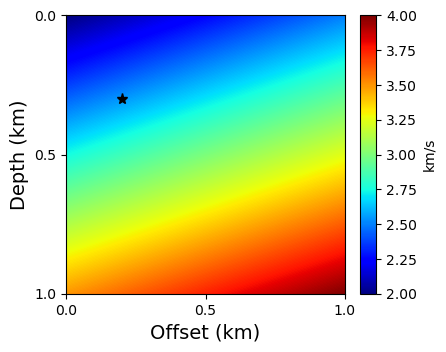

In [5]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(vz, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

In [6]:
# Computing high-order solutions

# Second-order accuracy
#Trich2 = Tfac2 + (Tfac2-Tfac1)/3.0

# Third-order accuracy
Tref = (16*Tfac4 - 8*Tfac2 + Tfac1)/9

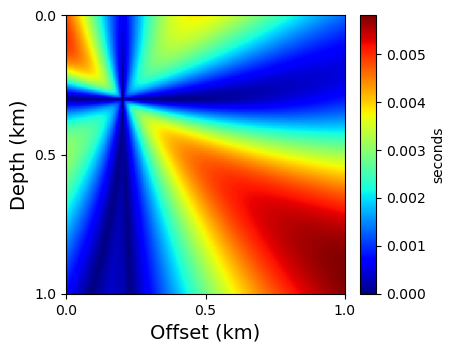

In [7]:
# Plot the traveltime solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(Tref-Tcomp), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

(array([-0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

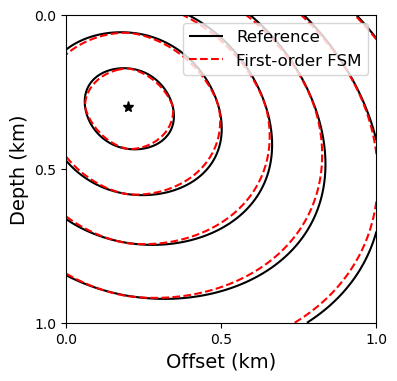

In [8]:
# Traveltime contour plots

plt.figure(figsize=(4,4))

ax = plt.gca()
im1 = ax.contour(Tref, 6, extent=[xmin,xmax,zmin,zmax], colors='k')
im2 = ax.contour(Tcomp, 6, extent=[xmin,xmax,zmin,zmax], colors='r',linestyles = 'dashed')

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
ax.legend([h1[0], h2[0]], ['Reference', 'First-order FSM'],fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

## Saving traveltime files

In [ ]:
np.save('../inputs/vofxzanisotropic/traveltimes/Tref.npy',Tref)
np.save('../inputs/vofxzanisotropic/traveltimes/Tcomp.npy',Tcomp)